In [ ]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from sqlalchemy import create_engine
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from os import environ
BIDEN_PAGE_ID = 7860876103 
TRUMP_PAGE_ID = 153080620724

engine = create_engine(environ.get("DATABASE_URL", "psql:///facebook_ads"))
MARKUP_CPM_START_DATE = date(2020, 7, 1)
MARKUP_CPM_END_DATE = date(2020, 10, 13)
minimum_ad_campaign_spend = 2000



## preliminaries

### swing states

In [3]:
SWING_STATES = [ # via Cook Political Report
    'Florida', 
    'Arizona', 
    'Georgia', 
    'North Carolina', 

    'Michigan', 
    'Pennsylvania', 
    'Wisconsin', 

    'Minnesota',
    'New Hampshire',
    'Nevada',
    
    'Iowa', 
    'Ohio', 
    'Texas',
]

BIDEN_PAGE_ID = 7860876103
TRUMP_PAGE_ID = 153080620724

SWING_STATE_CUTOFF = 1.5 * pd.read_sql("select sum(case when region = ANY(%(states)s) then population else 0 end)::float / sum(population) proportion  from region_populations", engine, params={"states":SWING_STATES})["proportion"][0]

In [4]:
SWING_STATE_CUTOFF

0.598504868799339

In [5]:
def get_swing_state_ads(page_id):
    ad_ids_and_proportions = pd.read_sql("""SELECT
        archive_id, 
        sum(case when region = ANY(%(swing_states)s) then spend_percentage else 0 end) as swing_state_proportion
    FROM ads 
    join region_impressions using (archive_id) 
    join impressions using (archive_id)
    join page_metadata using (page_id)
    where page_owner = %(page_id)s 
    and ad_creation_time > '2020-07-01'
    group by archive_id;""", engine, params={'page_id': page_id, 'swing_states': SWING_STATES})
    return ad_ids_and_proportions


In [6]:
biden_all_ad_ids_and_swing_proportions = get_swing_state_ads(BIDEN_PAGE_ID)

In [7]:
trump_all_ad_ids_and_swing_proportions = get_swing_state_ads(TRUMP_PAGE_ID)

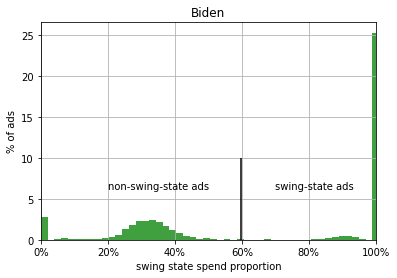

In [8]:
n, bins, patches = plt.hist(biden_all_ad_ids_and_swing_proportions["swing_state_proportion"], 50, density=True, facecolor='g', alpha=0.75)
pd.DataFrame({"proportion": n, "bin_left": bins[:-1]}).to_csv("swing_histogram_biden.csv")
plt.xlabel('swing state spend proportion')
plt.ylabel('% of ads')
plt.title('Biden')
plt.vlines(SWING_STATE_CUTOFF, 0, 40)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.annotate("swing-state ads", (0.7, 6.2))
plt.annotate("non-swing-state ads", (0.2, 6.2))
plt.xlim(0, 1)
plt.grid(True)
plt.show()

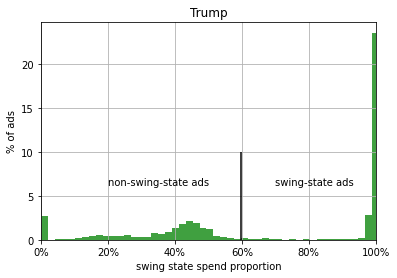

In [9]:
n, bins, patches = plt.hist(trump_all_ad_ids_and_swing_proportions["swing_state_proportion"], 50, density=True, facecolor='g', alpha=0.75)
pd.DataFrame({"proportion": n, "bin_left": bins[:-1]}).to_csv("swing_histogram_trump.csv")
plt.xlabel('swing state spend proportion')
plt.ylabel('% of ads')
plt.title('Trump')
plt.vlines(SWING_STATE_CUTOFF, 0, 40)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.annotate("swing-state ads", (0.7, 6.2))
plt.annotate("non-swing-state ads", (0.2, 6.2))
plt.xlim(0, 1)
plt.grid(True)
plt.show()

### getting ads

In [10]:
def get_ads(page_id):
    return pd.read_sql("""
    select page_name, 
        funding_entity, 
        ads.archive_id, 
        ads.ad_creative_body, 
        ads.ad_creation_time, 
        ad_delivery_start_time,
        min_impressions, max_impressions, 
        min_spend, max_spend,
        (min_spend + max_spend) / 2 spend_midpoint,
        potential_reach_min, potential_reach_max, 
        last_active_date 
    from ads 
    join pages using (page_id) 
    join impressions using (archive_id) 
    join page_metadata using (page_id) 
    where  page_owner = %(page_id)s and
    ad_creation_time > '2020-07-01'""", engine, params={"page_id": page_id})

#### Trump

In [11]:
trump_ads_unjoined = get_ads(TRUMP_PAGE_ID)
display(datetime.now())

datetime.datetime(2020, 10, 28, 16, 32, 48, 456684)

In [12]:
assert not trump_ads_unjoined.duplicated(subset=['archive_id']).any()
assert not trump_all_ad_ids_and_swing_proportions.duplicated(subset=['archive_id']).any()

In [13]:
trump_all_ads = trump_ads_unjoined.set_index("archive_id").join(trump_all_ad_ids_and_swing_proportions.set_index("archive_id"))
# trump_all_ads["ad_creative_body"] = trump_all_ads["ad_creative_body"].fillna('')
trump_all_ads["mid_imps"] = (trump_all_ads["min_impressions"] + trump_all_ads["max_impressions"])/2
trump_all_ads["mid_cpm_sm"] = trump_all_ads["spend_midpoint"] / trump_all_ads["mid_imps"] * 1000

trump_swing_ads = trump_all_ads[trump_all_ads["swing_state_proportion"] >= SWING_STATE_CUTOFF]
trump_nonswing_ads = trump_all_ads[~(trump_all_ads["swing_state_proportion"] >= SWING_STATE_CUTOFF)]


fn = "trump_all_ads_{}.csv".format(date.today())
trump_all_ads.reset_index().to_csv(fn)

print("Trump ads: {}".format(trump_all_ads.shape[0]))
fn = "trump_swing_ads_{}.csv".format(date.today())
trump_swing_ads.reset_index().to_csv(fn)

fn = "trump_nonswing_ads_{}.csv".format(date.today())
trump_nonswing_ads.reset_index().to_csv(fn)

Trump ads: 376426


#### Biden

In [14]:
all_biden_unjoined = get_ads(BIDEN_PAGE_ID)

In [15]:
assert not all_biden_unjoined.duplicated(subset=['archive_id']).any()
assert not biden_all_ad_ids_and_swing_proportions.duplicated(subset=['archive_id']).any()

In [16]:
biden_all_ads = all_biden_unjoined.set_index("archive_id").join(biden_all_ad_ids_and_swing_proportions.set_index("archive_id"))

# exclude a few ads from Harris's PAC before she became VP nominee
biden_all_ads = biden_all_ads[biden_all_ads["funding_entity"] != "FEARLESS FOR THE PEOPLE PAC"]

biden_all_ads["mid_imps"] = (biden_all_ads["min_impressions"] + biden_all_ads["max_impressions"])/2
biden_all_ads["mid_cpm_sm"] = biden_all_ads["spend_midpoint"] / biden_all_ads["mid_imps"] * 1000


biden_swing_ads = biden_all_ads[biden_all_ads["swing_state_proportion"] >= SWING_STATE_CUTOFF]
biden_nonswing_ads = biden_all_ads[~(biden_all_ads["swing_state_proportion"] >= SWING_STATE_CUTOFF)]

print("Biden ads: {}".format(biden_all_ads.shape[0]))

fn = "biden_all_ads_{}.csv".format(date.today())
biden_all_ads.reset_index().to_csv(fn)


fn = "biden_swing_ads_{}.csv".format(date.today())
biden_swing_ads.reset_index().to_csv(fn)

fn = "biden_nonswing_ads_{}.csv".format(date.today())
biden_nonswing_ads.reset_index().to_csv(fn)

Biden ads: 89978


# Summarizing ads

In [17]:
MINIMUM_AD_SPEND_FOR_MEDIANS = 2000
EXCLUDE_OVER1M_IMPS_ADS = True
EXCLUDE_UNDER100SPEND_OR_UNDER1000IMPS_ADS = True
def summarize_ads(biden_ads_unfiltered, 
              trump_ads_unfiltered, 
              name,
              minimum_ad_spend_for_medians=2000, 
              exclude_over1m_imps_ads = EXCLUDE_OVER1M_IMPS_ADS, 
              exclude_under100spend_or_under1000imps_ads = EXCLUDE_UNDER100SPEND_OR_UNDER1000IMPS_ADS,
              start_date=MARKUP_CPM_START_DATE.strftime("%Y-%m-%d"),
              end_date=MARKUP_CPM_END_DATE.strftime("%Y-%m-%d"),
                 
                 ):
    """ summarize a set of ads """
    print("{} start date: {}, end date: {}".format(name, start_date, end_date))
    trump_ads = trump_ads_unfiltered[(trump_ads_unfiltered["ad_creation_time"] > start_date) & (trump_ads_unfiltered["ad_creation_time"] < end_date)]
    biden_ads = biden_ads_unfiltered[(biden_ads_unfiltered["ad_creation_time"] > start_date) & (biden_ads_unfiltered["ad_creation_time"] < end_date)]

    trump_count_before = trump_ads.shape[0]
    biden_count_before = biden_ads.shape[0]
    trump_ads = trump_ads[trump_ads.apply( lambda x: (x['min_spend'] != 0 and x['max_impressions'] != 999) or not exclude_under100spend_or_under1000imps_ads, axis=1)]
    biden_ads = biden_ads[biden_ads.apply( lambda x: (x['min_spend'] != 0 and x['max_impressions'] != 999) or not exclude_under100spend_or_under1000imps_ads, axis=1)]
    trump_count_excluding_small = trump_ads.shape[0]
    biden_count_excluding_small = biden_ads.shape[0]
    trump_over_1m_imps_ads = trump_ads[trump_ads['min_impressions'] == 1000000 ]
    biden_over_1m_imps_ads = biden_ads[biden_ads['min_impressions'] == 1000000 ]
    
    trump_over_1m_imps_count = trump_over_1m_imps_ads.shape[0]
    biden_over_1m_imps_count = biden_over_1m_imps_ads.shape[0]
    trump_over_1m_imps_mean = trump_over_1m_imps_ads["min_spend"].sum() / trump_over_1m_imps_count
    biden_over_1m_imps_mean = biden_over_1m_imps_ads["min_spend"].sum() / biden_over_1m_imps_count
    
    print("{} Trump >1M avg cost: ${:,.0f} ({})".format(name, trump_over_1m_imps_mean, trump_over_1m_imps_count))
    print("{} Biden >1M avg cost: ${:,.0f} ({})".format(name, biden_over_1m_imps_mean, biden_over_1m_imps_count))
    trump_ads = trump_ads[trump_ads['min_impressions'].apply( lambda x: x != 1000000 or not exclude_over1m_imps_ads)]
    biden_ads = biden_ads[biden_ads['min_impressions'].apply( lambda x: x != 1000000 or not exclude_over1m_imps_ads)]

    print("{} Trump count {}".format(name, trump_ads.shape[0]))
    print("{} Biden count {}".format(name, biden_ads.shape[0]))
    
    biden_mid_cpmsm_avg = (biden_ads['spend_midpoint'].sum() / (biden_ads['mid_imps'].sum() / 1000))

    biden_spend_midpoint_total = biden_ads['spend_midpoint'].sum()
    biden_imps_midpoint_total  = biden_ads['mid_imps'].sum()
    
    
    trump_mid_cpmsm_avg = (trump_ads['spend_midpoint'].sum() / (trump_ads['mid_imps'].sum() / 1000))

    trump_spend_midpoint_total = trump_ads['spend_midpoint'].sum()
    trump_imps_midpoint_total  = trump_ads['mid_imps'].sum()

    print(f"{name} trump mean (mid imps, mid spend): ${trump_mid_cpmsm_avg:0.2f}")
    print(f"{name} biden mean (mid imps, mid spend): ${biden_mid_cpmsm_avg:0.2f}")

    biden_ads_over_min = biden_ads[biden_ads["spend_midpoint"] > minimum_ad_spend_for_medians]
    trump_ads_over_min = trump_ads[trump_ads["spend_midpoint"] > minimum_ad_spend_for_medians]

    biden_q1_cpm = np.percentile(biden_ads_over_min["mid_cpm_sm"], 25)
    biden_med_cpm = np.percentile(biden_ads_over_min["mid_cpm_sm"], 50)
    biden_q3_cpm = np.percentile(biden_ads_over_min["mid_cpm_sm"], 75)

    trump_q1_cpm = np.percentile(trump_ads_over_min["mid_cpm_sm"], 25)
    trump_med_cpm = np.percentile(trump_ads_over_min["mid_cpm_sm"], 50)
    trump_q3_cpm = np.percentile(trump_ads_over_min["mid_cpm_sm"], 75) 

    biden_over_trump_q3 = 100 * biden_ads_over_min["mid_cpm_sm"].gt(np.percentile(trump_ads_over_min["mid_cpm_sm"], 75)).mean()

    print()
    return {
        "biden": {
            "mean": biden_mid_cpmsm_avg,
            "spend_midpoint_total": biden_spend_midpoint_total,
            "imps_midpoint_total": biden_imps_midpoint_total, 
            "total_ads": biden_count_before,
            "excluded_small": biden_count_before - biden_count_excluding_small,
            "excluded_large_count": biden_over_1m_imps_count,
            "ads_after_exclusions": biden_ads.shape[0],
            "excluded_large_mean": biden_over_1m_imps_mean

        },
        "trump": {
            "mean": trump_mid_cpmsm_avg,
            "spend_midpoint_total": trump_spend_midpoint_total,
            "imps_midpoint_total": trump_imps_midpoint_total, 
            "total_ads": trump_count_before,
            "excluded_small": trump_count_before - trump_count_excluding_small,
            "excluded_large_count": trump_over_1m_imps_count,
            "ads_after_exclusions": trump_ads.shape[0],
            "excluded_large_mean": trump_over_1m_imps_mean

        }
    }
    

In [18]:
trump_all_ads = pd.read_csv("trump_all_ads_2020-10-15.csv")
biden_all_ads = pd.read_csv("biden_all_ads_2020-10-15.csv")

all_ads_summary = summarize_ads(biden_all_ads, trump_all_ads, "all ads")

all ads start date: 2020-07-01, end date: 2020-10-13
all ads Trump >1M avg cost: $25,349 (437)
all ads Biden >1M avg cost: $41,222 (311)
all ads Trump count 60161
all ads Biden count 23046
all ads trump mean (mid imps, mid spend): $23.09
all ads biden mean (mid imps, mid spend): $25.53



In [19]:
all_ads_JulyAug_summary = summarize_ads(biden_all_ads, trump_all_ads, "all ads", start_date="2020-07-01", end_date="2020-09-01")
print("-----------" * 5)
all_ads_SeptOct_summary = summarize_ads(biden_all_ads, trump_all_ads, "all ads", start_date="2020-09-01", end_date="2020-10-15");


all ads start date: 2020-07-01, end date: 2020-09-01
all ads Trump >1M avg cost: $22,931 (367)
all ads Biden >1M avg cost: $54,000 (135)
all ads Trump count 28954
all ads Biden count 9037
all ads trump mean (mid imps, mid spend): $20.35
all ads biden mean (mid imps, mid spend): $28.55

-------------------------------------------------------
all ads start date: 2020-09-01, end date: 2020-10-15
all ads Trump >1M avg cost: $38,824 (68)
all ads Biden >1M avg cost: $31,599 (172)
all ads Trump count 30193
all ads Biden count 13757
all ads trump mean (mid imps, mid spend): $26.56
all ads biden mean (mid imps, mid spend): $24.01



In [20]:
print("swing state ads (not campaigns)")
trump_swing_ads = pd.read_csv("trump_swing_ads_2020-10-15.csv")
biden_swing_ads = pd.read_csv("biden_swing_ads_2020-10-15.csv")

swing_ads_summary = summarize_ads(biden_swing_ads, trump_swing_ads, "swing ads")

swing state ads (not campaigns)
swing ads start date: 2020-07-01, end date: 2020-10-13
swing ads Trump >1M avg cost: $34,995 (96)
swing ads Biden >1M avg cost: $29,537 (108)
swing ads Trump count 27986
swing ads Biden count 13292
swing ads trump mean (mid imps, mid spend): $25.22
swing ads biden mean (mid imps, mid spend): $27.35



In [21]:
print("swing state ads (not campaigns)")
trump_swing_ads = pd.read_csv("trump_swing_ads_2020-10-15.csv")
biden_swing_ads = pd.read_csv("biden_swing_ads_2020-10-15.csv")


swing_ads_JulyAug_summary = summarize_ads(biden_swing_ads, trump_swing_ads, "swing ads", start_date="2020-07-01", end_date="2020-09-01")
print("-----------" * 5)
swing_ads_SeptOct_summary = summarize_ads(biden_swing_ads, trump_swing_ads, "swing ads", start_date="2020-09-01", end_date="2020-10-15")

swing state ads (not campaigns)
swing ads start date: 2020-07-01, end date: 2020-09-01
swing ads Trump >1M avg cost: $23,685 (46)
swing ads Biden >1M avg cost: $33,056 (18)
swing ads Trump count 5858
swing ads Biden count 4252
swing ads trump mean (mid imps, mid spend): $16.55
swing ads biden mean (mid imps, mid spend): $34.34

-------------------------------------------------------
swing ads start date: 2020-09-01, end date: 2020-10-15
swing ads Trump >1M avg cost: $45,400 (50)
swing ads Biden >1M avg cost: $28,833 (90)
swing ads Trump count 21888
swing ads Biden count 8996
swing ads trump mean (mid imps, mid spend): $28.21
swing ads biden mean (mid imps, mid spend): $25.19



In [22]:
print("non-swing state ads (not campaigns)")
trump_nonswing_ads = pd.read_csv("trump_nonswing_ads_2020-10-15.csv")
biden_nonswing_ads = pd.read_csv("biden_nonswing_ads_2020-10-15.csv")
nonswing_summary = summarize_ads(biden_nonswing_ads, trump_nonswing_ads, "non-swing ads")

non-swing state ads (not campaigns)
non-swing ads start date: 2020-07-01, end date: 2020-10-13
non-swing ads Trump >1M avg cost: $22,633 (341)
non-swing ads Biden >1M avg cost: $47,438 (203)
non-swing ads Trump count 32175
non-swing ads Biden count 9754
non-swing ads trump mean (mid imps, mid spend): $21.66
non-swing ads biden mean (mid imps, mid spend): $23.11

